In [1]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121

from PIL import Image
import gdown
from IPython import display

# Load image
image_data_url = 'https://drive.google.com/uc?id=1y4nufMQqQByiz2TpXIyRDv1MxQU4caMy'
image_data_path = './example.jpg'
gdown.download(image_data_url, image_data_path, True)

image2_url = 'https://drive.google.com/uc?id=1_WpFbGEuS2r19UeP6wekbcF0kb-0nH18'
image2_path ='./image.jpg'
gdown.download(image2_url, image2_path, True)

gif_url = 'https://drive.google.com/uc?id=1kQa0LViX33gFxdTroFVSzM11-FHypaD3'
gif_path = './sliding.gif.png'
gdown.download(gif_url, gif_path, True)

# Show sliding windows
def show_sliding_window():
  return display.Image(filename="sliding.gif.png")

# Construct vehicle dataset
label_car = 1
label_truck = 9

# Load data
def load_cifar10():
  (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()
  y_train_cifar = y_train_cifar.squeeze()
  y_test_cifar = y_test_cifar.squeeze()
  return (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar)

# CIFAR100 classes
idx_to_class = ['background', 'car', 'truck']

# Construct vehicle dataset from CIFAR10
def construct_vehicle_dataset(data, labels, images_per_class, label_car=1, label_truck=9):
  mask_car = labels == label_car
  mask_truck = labels == label_truck

  mask_vehicles = mask_car | mask_truck
  mask_background = np.invert(mask_vehicles)
  
  data_car = data[mask_car]
  data_truck = data[mask_truck]
  data_background = data[mask_background][:images_per_class]

  new_data = np.vstack((data_background, data_car, data_truck))
  new_labels = np.repeat(np.array([0, 1, 2]), images_per_class, axis=0)
  
  return new_data, new_labels

def load_vehicle_dataset():
  (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = load_cifar10()
  x_train, y_train = construct_vehicle_dataset(x_train_cifar, y_train_cifar, 5000)
  x_test, y_test = construct_vehicle_dataset(x_test_cifar, y_test_cifar, 1000)
  return (x_train, y_train), (x_test, y_test)

# plotting
def plot_one_image(data, labels = [], index = None, image_shape = None, fig_size=None):
  '''
  if data is a single image, display that image

  if data is a 4d stack of images, display that image
  '''
  ### cv2.imshow('image', data)    
  num_dims   = len(data.shape)
  num_labels = len(labels)
  if image_shape is not None:
    target_shape = image_shape
  else:
    target_shape = (32, 32, 3)
  # reshape data if necessary
  if num_dims == 1:
    data = data.reshape(target_shape)
  if num_dims == 2:
    data = data.reshape(np.vstack[-1, image_shape])
  num_dims   = len(data.shape)

  # check if single or multiple images
  if num_dims == 3:
    if num_labels > 1:
      print('Multiple labels does not make sense for single image.')
      return

    label = labels      
    if num_labels == 0:
      label = ''
    image = data

  if num_dims == 4:
    image = data[index, :]
    label = labels[index]

  # plot image of interest
  print('Label: %s'%label)
  if fig_size is not None:
    plt.figure(figsize=fig_size)
  plt.imshow(image)
  plt.show()

def model_to_string(model):
  import re
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  sms = "\n".join(stringlist)
  sms = re.sub('_\d\d\d','', sms)
  sms = re.sub('_\d\d','', sms)
  sms = re.sub('_\d','', sms)  
  return sms

def normalize(data):
  # CIFAR100 mean (0.4914, 0.4822, 0.4465) std (0.2023, 0.1994, 0.2010)
  return (data/255-np.array((0.4914, 0.4822, 0.4465))) / np.array((0.2023, 0.1994, 0.2010))

def label_to_onehot(labels):
  final_labels = np.zeros((len(labels), 3))
  for i in range(len(labels)):
    label = labels[i]
    if label == 0:
      final_labels[i,:] = np.array([1, 0, 0])
    if label == 1:
      final_labels[i,:] = np.array([0, 1, 0])
    if label == 2:
      final_labels[i,:] = np.array([0, 0, 1])
  return final_labels

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
  # i'm sorry for this function's code. i am so sorry. 
  history = history.history
  history.update({'epoch':list(range(len(history['val_accuracy'])))})
  history = pd.DataFrame.from_dict(history)

  best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

  if not ax:
    f, ax = plt.subplots(1,1)
  sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
  sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
  ax.axhline(0.333, linestyle = '--',color='red', label = 'Chance')
  ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
  ax.legend(loc = 1)    
  ax.set_ylim([0.01, 1])

  ax.set_xlabel(xlabel)
  ax.set_ylabel('Accuracy (Fraction)')
  
  plt.show()


def TransferClassifier_func(name, nn_params, trainable = True):
  expert_dict = {'VGG16': VGG16, 
                  'VGG19': VGG19,
                  'ResNet50':ResNet50,
                  'DenseNet121':DenseNet121}

  expert_conv = expert_dict[name](weights = 'imagenet', 
                                            include_top = False, 
                                            input_shape = nn_params['input_shape'])
  for layer in expert_conv.layers:
    layer.trainable = trainable
    
  expert_model = Sequential()
  expert_model.add(expert_conv)
  expert_model.add(GlobalAveragePooling2D())

  expert_model.add(Dense(128, activation = 'relu'))
  expert_model.add(Dropout(0.3))

  expert_model.add(Dense(64, activation = 'relu'))

  expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

  expert_model.compile(loss = nn_params['loss'], 
                optimizer = optimizers.SGD(lr=nn_params['learning_rate'], momentum=nn_params['momentum']), 
                metrics=['accuracy'])

  return expert_model

# neural net parameters
image_shape          = (32, 32, 3)
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 3
nn_params['loss']              = 'categorical_crossentropy'
nn_params['output_activation'] = 'softmax'
nn_params['learning_rate'] = 1e-3
nn_params['momentum'] = 0.9

TransferClassifier  = lambda name: TransferClassifier_func(name = name, nn_params = nn_params);

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We're going to train some models that are a bit more complicated than a perceptron, so make sure you are using GPU by running the following code.

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Today, we will be working with the following image, which we will apply objection detection to.

(100, 160, 3)
Label: 


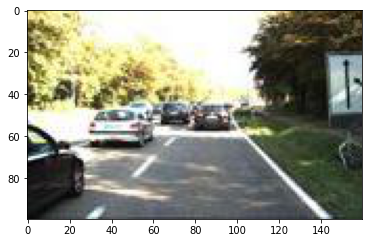

In [3]:
import numpy as np

image = np.asarray(Image.open('./example.jpg'))
print(image.shape)
plot_one_image(image)

# Milestone 1. Implementing the sliding window algorithm

Remember our discussion about how to solve the object detection problem? 

We broke the problem into 2 parts, localization and recognition. 

We already have an image classifier for vehicle recognition now, then how can we make use of this image classifier for object detection?

One naive method is to apply the classifier on sliding windows of the input image.

In [4]:
show_sliding_window()

Output hidden; open in https://colab.research.google.com to view.

As you can see from the gif above, a sliding window technique is that we slide through the image, looking at cropped images of a fixed size.

To implement this sliding window algorithm, let's first figure out how to crop an image. 



### Exercise (Coding) | Image Cropping

You've probably used an image crop before, where you segment part of an image out, like below: 

![](https://drive.google.com/uc?export=view&id=1EAw4z5a96OvL77jNAf9v6f7ItvUaGFGm)

How can we implement this in Python?

In [5]:
# first copy our image... Make sure to copy it! Otherwise, we may accidentally overwrite our original image.
new_image = image.copy()
print(new_image.shape)

(100, 160, 3)


In [6]:
#@title What does image shape represent? { display-mode: "form" }

#@markdown What does the bold number (**100**, 160, 3) represent? 
Dimension_0  = "image height" #@param ["number of images", "image width", "image height","number of colors","fill in"]
  
#@markdown What does the bold number (100, **160**, 3) represent? 
Dimension_1  = "image width" #@param ["number of images", "image width", "image height","number of colors","fill in"]

#@markdown What does the bold number (100, 160, **3**) represent? 
Dimension_2  = "number of colors" #@param ["number of images", "image width", "image height","number of colors","fill in"]

if Dimension_0 == 'image height':
  print("Yes! Dimension_0 is the height of the image.")
else:
  print("Try again for Dimension_0!")

if Dimension_1 == 'image width':
  print("Yes! Dimension_1 is the width of the image.")
else:
  print("Try again for Dimension_1!")
  
if Dimension_2 == 'number of colors':
  print("Yes! Dimension_2 stands for 3 colors - (r,g,b).")
else:
  print("Try again for Dimension_2!")


Yes! Dimension_0 is the height of the image.
Yes! Dimension_1 is the width of the image.
Yes! Dimension_2 stands for 3 colors - (r,g,b).


We want to get a rectangle crop whose top left corner is at `(x, y)` of the image. The height and width of the cropping window is `window_h` and `window_w` respectively. Can you implement this on the `new_image` and plot your result?


Label: 


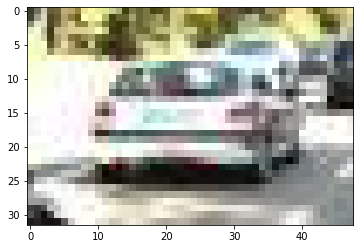

In [7]:
x = 20
y = 40
window_h = 32
window_w = 48

### YOUR CODE HERE
plot_one_image(new_image[y:window_h+y, x:window_w+x])
### END CODE

### Exercise (Coding) | Sliding Windows

The sliding windows are crops at multiple `(x, y)` positions. To get the sliding windows, we can just iterate through `(x, y)` positions and do the cropping as what we did above. 

Next, let's add a for loop to get our sliding windows! 

Label: 


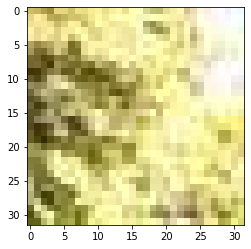

Label: 


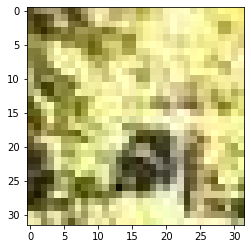

Label: 


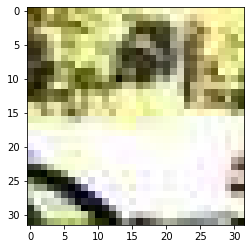

Label: 


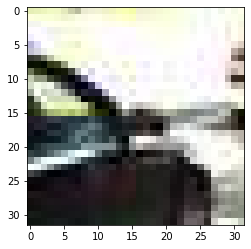

Label: 


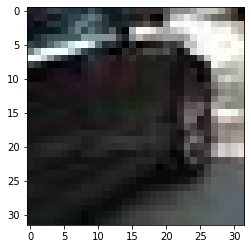

Label: 


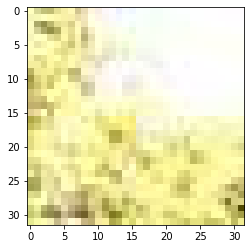

Label: 


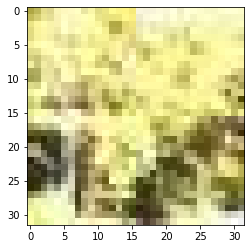

Label: 


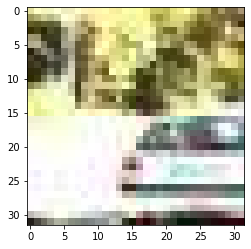

Label: 


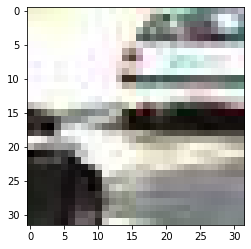

Label: 


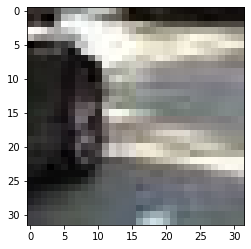

Label: 


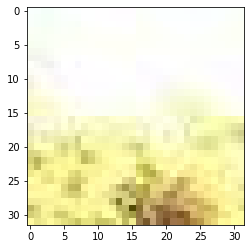

Label: 


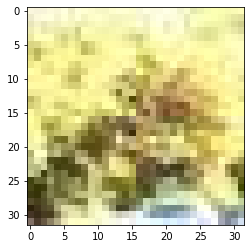

Label: 


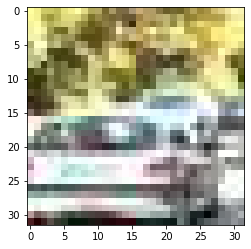

Label: 


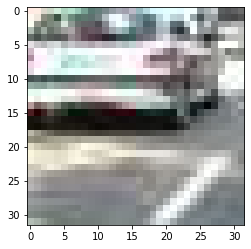

Label: 


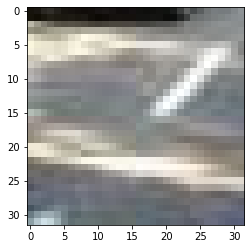

Label: 


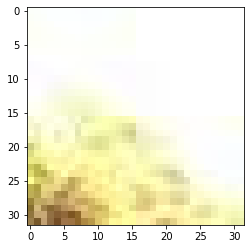

Label: 


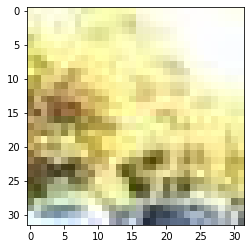

Label: 


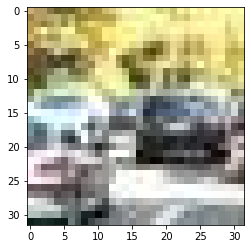

Label: 


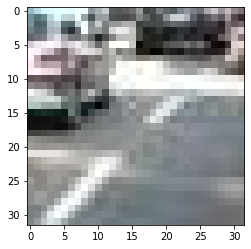

Label: 


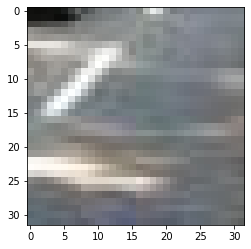

Label: 


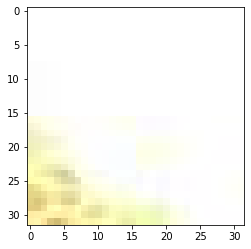

Label: 


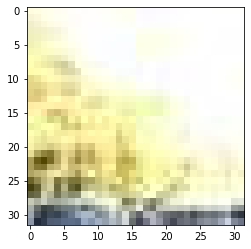

Label: 


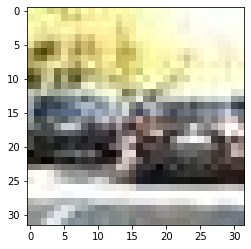

Label: 


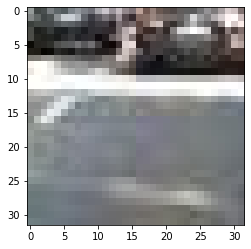

Label: 


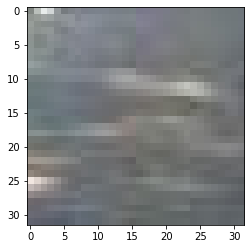

Label: 


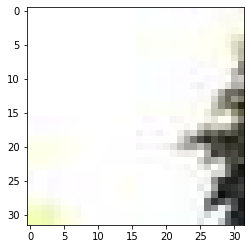

Label: 


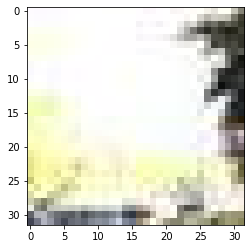

Label: 


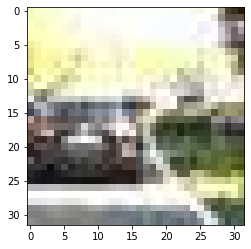

Label: 


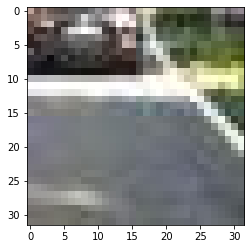

Label: 


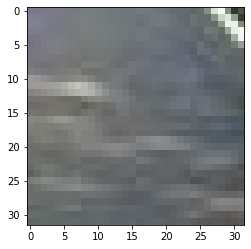

Label: 


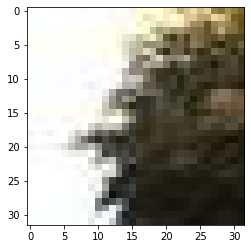

Label: 


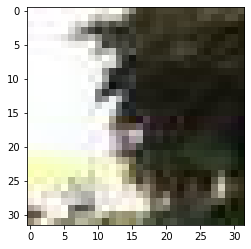

Label: 


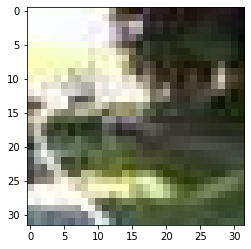

Label: 


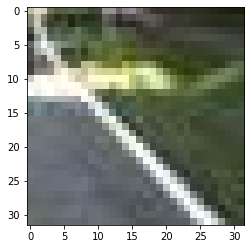

Label: 


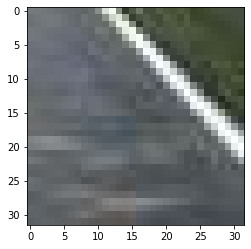

Label: 


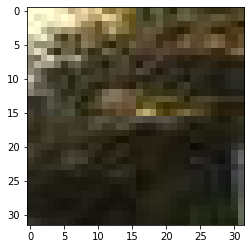

Label: 


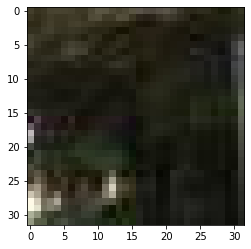

Label: 


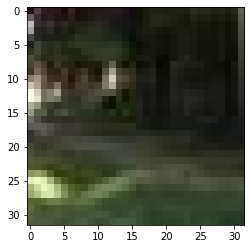

Label: 


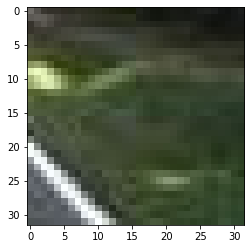

Label: 


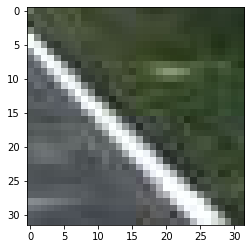

Label: 


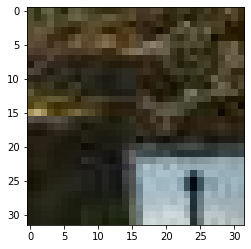

Label: 


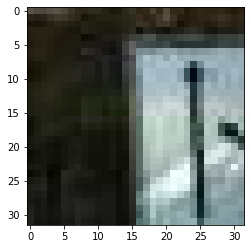

Label: 


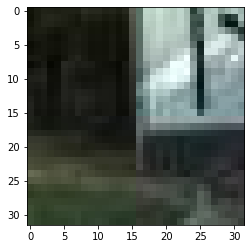

Label: 


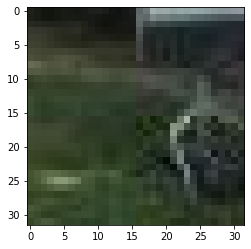

Label: 


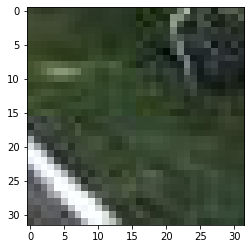

In [8]:
step_h = 16
step_w = 16
window_h = 32
window_w = 32
image_h=new_image.shape[0]
image_w=new_image.shape[1]

# Save your results in this list
windows = []   

### YOUR CODE HERE
for x1 in range(0, image_w, step_w):
  for y1 in range(0, image_h, step_h):
    window = new_image[y1 : window_h + y1, x1 : window_w + x1]
    if (window.shape[0] == window_h and window.shape[1] == window_w):
      windows.append(window)

for window in windows:
  plot_one_image(window)
### END CODE

In [9]:
#@title Run this to test if your code is right!

count = 0
for w in windows:
  if w.shape != (window_h, window_w, 3):
    count += 1
if count != 0:
  print("Please check again. Some of your windows are not in the correct size of ({}, {}, 3)".format(window_h, window_w))
else:
  print("All the windows are in the correct size! Well done!")

if len(windows) == 45:
  print("You get correct number of windows! Well done!")
else:
  print("Please check again. The number of windows is wrong.")

All the windows are in the correct size! Well done!
You get correct number of windows! Well done!


Recall that the label and class name mapping is
```
0 - background
1 - car
2 - truck
```
We have created labels for the windows in advance, as defined below. Now let's plot all the windows and their labels to check what you've got! Hopefully, the labels look reasonable to you.

In [10]:
labels = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0])

Label: [0]


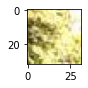

Label: [0]


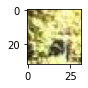

Label: [0]


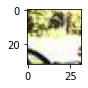

Label: [0]


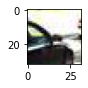

Label: [0]


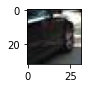

Label: [0]


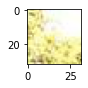

Label: [0]


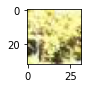

Label: [0]


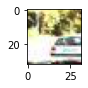

Label: [0]


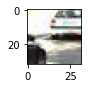

Label: [0]


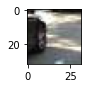

Label: [0]


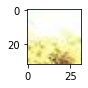

Label: [0]


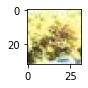

Label: [0]


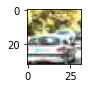

Label: [0]


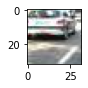

Label: [0]


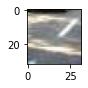

Label: [0]


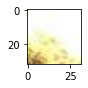

Label: [0]


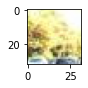

Label: [0]


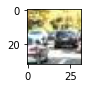

Label: [0]


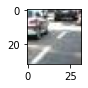

Label: [1]


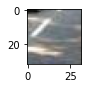

Label: [1]


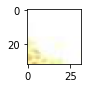

Label: [1]


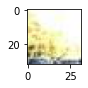

Label: [1]


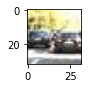

Label: [1]


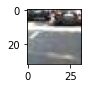

Label: [0]


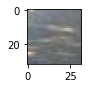

Label: [0]


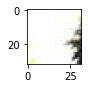

Label: [0]


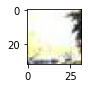

Label: [1]


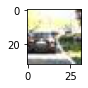

Label: [1]


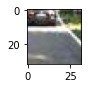

Label: [1]


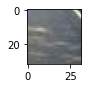

Label: [1]


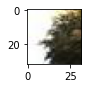

Label: [1]


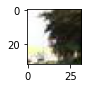

Label: [1]


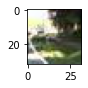

Label: [0]


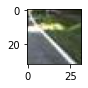

Label: [0]


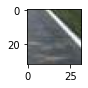

Label: [0]


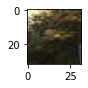

Label: [1]


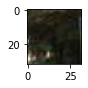

Label: [0]


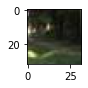

Label: [0]


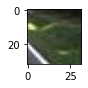

Label: [0]


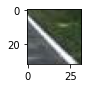

Label: [0]


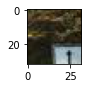

Label: [0]


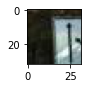

Label: [0]


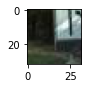

Label: [0]


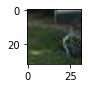

Label: [0]


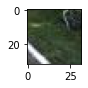

In [11]:
for window, label in zip(windows, labels):
  plot_one_image(window, [label], fig_size=(1, 1))

Recall that the inputs to our neural network models are `numpy` arrays, we need to convert our `windows` list to a `numpy` array. You can do this using the function `numpy.stack()`, which joins a sequence of same dimension arrays along a new axis. Also check if the shape of the result array is what you expect!





In [12]:
import numpy as np

### YOUR CODE HERE
print(len(windows))
windows = np.stack(windows)
print(windows.shape)
### END CODE

45
(45, 32, 32, 3)


# Milestone 2. Vehicle Recognition Prediction on Sliding Windows

Once we have the patches of the cropped image saved in the numpy array `windows`, we can now apply the perceptron that we trained to recognize cars.

As what we did exactly, let's load the vehicle dataset, build the perceptron model and train it on the dataset!

In [13]:
# grab tools from our tensorflow and keras toolboxes!
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [14]:
# Load data
(x_train, y_train), (x_test, y_test) = load_vehicle_dataset()

170500096/170498071 [==============================] - 4s 0us/step


In [15]:
# Build model
perceptron = Sequential()
perceptron.add(Flatten(input_shape = (32, 32, 3)))
perceptron.add(Dense(units = 128, activation = 'relu'))
perceptron.add(Dense(units = 3, activation = 'softmax'))
    
perceptron.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.8614 - accuracy: 0.6359 - val_loss: 0.7579 - val_accuracy: 0.6883
Epoch 2/20
469/469 [==============================] - 2s 3ms/step - loss: 0.6716 - accuracy: 0.7209 - val_loss: 0.7231 - val_accuracy: 0.7003
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 0.6029 - accuracy: 0.7527 - val_loss: 0.6892 - val_accuracy: 0.7073
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.5562 - accuracy: 0.7721 - val_loss: 0.6788 - val_accuracy: 0.7220
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 0.5126 - accuracy: 0.7977 - val_loss: 0.6893 - val_accuracy: 0.7187
Epoch 6/20
469/469 [==============================] - 1s 3ms/step - loss: 0.4724 - accuracy: 0.8142 - val_loss: 0.6893 - val_accuracy: 0.7177
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 0.4393 - accuracy: 0.8311 - val_loss: 0.6952 - val_accuracy: 0.7170
Epoch 

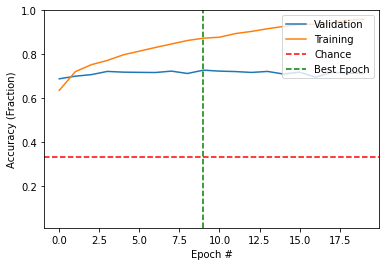

In [16]:
# Preprocess data
monitor = ModelCheckpoint('./model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

x_train_norm = normalize(x_train)
x_test_norm = normalize(x_test)

y_train_onehot = label_to_onehot(y_train)
y_test_onehot = label_to_onehot(y_test)

# Train the model
history = perceptron.fit(x_train_norm, y_train_onehot, epochs=20, validation_data=(x_test_norm, y_test_onehot), shuffle=True, callbacks=[monitor])

plot_acc(history)

Our perceptron model can recognize cars and trucks at around 95% accuracy on the training set and around 72% accuracy on the test set! Although it's not perfect, it's already capable of recognizing cars to some degree. 

Now as we have both the sliding windows and the trained model, let's try to combine these two to create a simple vehicle detector!


### Exercise (Coding) | Prediction on Sliding Windows


Given the sliding windows `windows`, we want to get the `perceptron`'s predictions `pred_y` about whether each patch contains a car/truck or not. We also want to get the model's confidence `pred_prob` about the prediction.

As a hint, ...

* Don't forget to `normalize` the input data before feeding it into the model
* To get the model's outputs for the inputs, we use `perceptron.predict(input_data)`. 
* The output of the model is the predicted probability over the 3 classes: car, truck and others. For each input image, the model chooses the predicted class to be the one with the highest probability. That probability is regarded as the model's confidence on this prediction.
* `numpy.max()` and `numpy.argmax()` may be useful.


In [17]:
### YOUR CODE HERE

windows_norm = normalize(windows)

output = perceptron.predict(windows_norm)

pred_y = np.argmax(output, axis=-1)
pred_prob = np.max(output, axis=-1)
print(pred_prob)
### END CODE

[0.9999974  0.99225533 0.9997483  0.9974577  0.95408845 0.9998387
 0.9973828  0.9184319  0.55475837 0.57078624 0.9999881  0.9968078
 0.99156344 0.8871159  0.79807866 0.99998605 0.9993512  0.9999925
 0.9656839  0.796928   0.99990416 0.99954295 0.8342228  0.9727058
 0.67709905 0.9999999  0.9954366  0.9564422  0.99990094 0.83714724
 0.9918041  0.9971125  0.9949226  0.7960734  0.9641041  0.71579885
 0.58769476 0.8375017  0.86667055 0.94493407 0.77451175 0.99992967
 0.4361503  0.89775336 0.52000386]


Now we have our results saved in `pred_y` and `pred_prob`. To better understand how our model is doing, let's plot the detected cars and trucks! 

We can set a confidence `threshold`, so that only the predictions that have higher confidence than the given `threshold` will be plotted.

Can you fill in the if condition below, to only plot the windows that are recognized to be car/truck and with a higher prediction confidence than the given `threshold`?

Recall that the label and class name mapping is
```
0 - background
1 - car
2 - truck
```

Label: ['1 0.9997483']


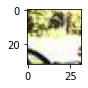

Label: ['1 0.9184319']


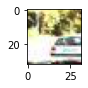

Label: ['1 0.8871159']


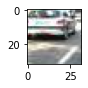

Label: ['2 0.9999925']


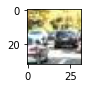

Label: ['2 0.8342228']


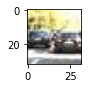

Label: ['1 0.9727058']


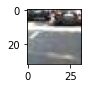

Label: ['2 0.9564422']


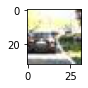

Label: ['1 0.99990094']


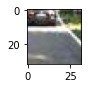

Label: ['1 0.9641041']


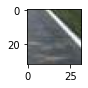

In [18]:
threshold = 0.6

num_windows = windows.shape[0]
for i in range(num_windows):
  ### YOUR CODE HERE
  # if [CONDITION]:
  if pred_prob[i] > threshold and pred_y[i] > 0:
  ### END CODE
    plot_one_image(windows[i], labels=[" ".join([str(pred_y[i]), str(pred_prob[i])])], fig_size=(1,1))

We can also calculate the accuracy of our predictions by comparing the predictions and the labels. 

In [19]:
np.mean(pred_y == labels)

0.6444444444444445

In order to reuse the code easily, let's include the prediction, plotting and calculating accuracy in one function, which returns the accuracy.

In [20]:
def sliding_predictions(model, windows, threshold=0.6, labels=labels):
  ### Copy the prediction code here
  windows_norm = normalize(windows)

  output = perceptron.predict(windows_norm)

  pred_y = np.argmax(output, axis=-1)
  pred_prob = np.max(output, axis=-1)
  ### Copy the plotting code here
  num_windows = windows.shape[0]
  for i in range(num_windows):
  ### YOUR CODE HERE
  # if [CONDITION]:
    if pred_prob[i] > threshold and pred_y[i] > 0:
  ### END CODE
      plot_one_image(windows[i], labels=[" ".join([str(pred_y[i]), str(pred_prob[i])])], fig_size=(1,1))
  ### Return the accuracy
  return np.mean(pred_y == labels)

**Are you satisfied with the detection results?**

Next, we'll try some different image recognition models. Hopefully, we can get a better detector!

# Milestone 3. Exploring Convolutional Neural Networks


Convolutional Neural Networks tend to perform much better on images, compared with the perceptron model. 

So, how is a convolutional neural network specified in tensorflow/keras? Let's walk through this!

### Exercise (Coding) | Building a CNN model


Our convolutional neural network is specified like: 

```
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), input_shape=(__, __, __)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten()) 
cnn.add(Dense(units = 128, activation = 'relu'))
cnn.add(Dense(units = NUM_OUTPUTS, activation = 'softmax'))
```

We see that we have a 1 convolution layer that takes in our inputs, and then 2 dense layers. Overall this is a 3 layer network. 

After specifying the network, we can compile it and train it just like before! Note:
* we want loss to be `'categorical_crossentropy'`
* our optimizer will be  `optimizers.SGD(lr=1e-3, momentum=0.95)`
* our metric is `['accuracy']`

In [21]:
### YOUR CODE HERE
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten()) 
cnn.add(Dense(units = 128, activation = 'relu'))
cnn.add(Dense(units = 3, activation = 'softmax'))
# specify the network

# compile the network
cnn.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.95),
              metrics=['accuracy'])
### END CODE

Once we've compiled the network, train it for 20 epochs.



In [22]:
### YOUR CODE HERE
cnn.fit(x_train_norm, y_train_onehot, epochs=20, validation_data = (x_test_norm, y_test_onehot), shuffle=True, callbacks=[monitor])
### END CODE

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.7387 - accuracy: 0.6785 - val_loss: 0.5616 - val_accuracy: 0.7710
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.5324 - accuracy: 0.7845 - val_loss: 0.5158 - val_accuracy: 0.7873
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.4566 - accuracy: 0.8173 - val_loss: 0.4790 - val_accuracy: 0.8093
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3944 - accuracy: 0.8473 - val_loss: 0.4366 - val_accuracy: 0.8253
Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 0.3320 - accuracy: 0.8692 - val_loss: 0.4478 - val_accuracy: 0.8217
Epoch 6/20
469/469 [==============================] - 2s 3ms/step - loss: 0.2765 - accuracy: 0.8952 - val_loss: 0.4617 - val_accuracy: 0.8273
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2202 - accuracy: 0.9185 - val_loss: 0.4286 - val_accuracy: 0.8353
Epoch 

And see how well it did!

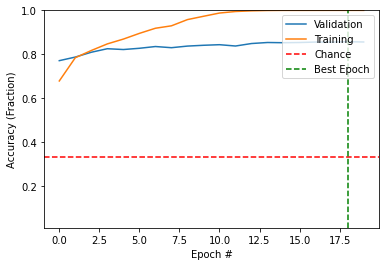

In [23]:
### YOUR CODE HERE
plot_acc(cnn.history)
### END CODE

Nice training accuracy!

**Do you think this CNN model is better than the perceptron?**

**Does the model still overfit?**

Same as how we got a simple vehicle detector by applying the trained perceptron to classifying the sliding windows, we can apply our new model as well. Just call the function `sliding_predictions(model, windows, threshold)` with our new model `cnn`!

Label: ['1 0.9997483']


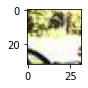

Label: ['1 0.9184319']


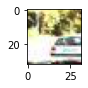

Label: ['2 0.9999925']


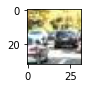

Label: ['1 0.9727058']


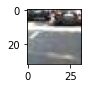

Label: ['2 0.9564422']


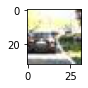

Label: ['1 0.99990094']


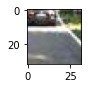

Label: ['1 0.9641041']


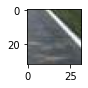

0.6444444444444445

In [24]:
### YOUR CODE HERE
sliding_predictions(cnn, windows, 0.9)
### END CODE

Is this CNN model better than the perceptron?


# Milestone 4. Expert models: Transfer learning

For all of the machine leanring we've done thus far, we've used models that were built from 'scratch'. All of these models are like newborn babies that have neither seen nor explored the world. 

And, despite their cuteness, these babies require **a lot of education** to do much anything useful. 

Unfortunately, our training manual is pretty small to all the things in the big wide world. So, just training on our manual is going to be inherently limited. 


Luckily, there are **non-babies** (who we will refer to as experts) who have been out in the world for a long time! While these non-babies haven't seen our task, they have experience with a lot of other things. We can hand them our training manual and reasonably expect that they will pick up our task fairly quickly. 

In deep learning, the idea of using a model trained on another task as a starting point for your model is known as **transfer learning**. 

## Activity 4a. Transfer learning for vehicle recognition


### Instructor-Led Discussion

For our transfer learning, we're going to use 'experts' built upon the famous 'ImageNet' classification problem. 

In ImageNet, participants were challenged to build machine learning models that could distinguish 14 million images' categories, where there were > 20,000 categories available. 

Below, we see examples of 4 different categories. 

![](http://cs231n.github.io/assets/trainset.jpg)



One of the experts we can use is VGG 16. VGG 16 was a network that was allowed to study the 14 million images 74 times. 

After its studying, VGG 16 was able to guess something close to the real label (top-5 accuracy) better than a human can.

![](https://cdn-images-1.medium.com/max/1600/0*V1muWIDnPVwZUuEv.png)

We're going to take an expert model like VGG16 and let it train on OUR images. Hopefully, their experience with those 14 million images will help it understand driver distraction.

### Exercise (Coding) | Within a student group

Let's tap an expert model to help us out with our driver distraction prediction!

We provide a wrapper that lets you 'call' up and employ expert models. You can call it like...

```
transfer = TransferClassifier(name = 'VGG16')
```

The experts we have on hand are:
* `VGG16`
* `VGG19`
* `ResNet50`
* `DenseNet121`



Afterwards, see if you can get 95% validation accuracy with your model!

Epoch 1/20
469/469 [==============================] - 10s 21ms/step - loss: 0.3914 - accuracy: 0.8478 - val_loss: 0.3154 - val_accuracy: 0.8723
Epoch 2/20
469/469 [==============================] - 10s 21ms/step - loss: 0.1850 - accuracy: 0.9339 - val_loss: 0.2059 - val_accuracy: 0.9260
Epoch 3/20
469/469 [==============================] - 9s 20ms/step - loss: 0.1295 - accuracy: 0.9541 - val_loss: 0.2461 - val_accuracy: 0.9163
Epoch 4/20
469/469 [==============================] - 10s 20ms/step - loss: 0.1028 - accuracy: 0.9642 - val_loss: 0.2012 - val_accuracy: 0.9293
Epoch 5/20
469/469 [==============================] - 10s 20ms/step - loss: 0.0692 - accuracy: 0.9755 - val_loss: 0.1898 - val_accuracy: 0.9407
Epoch 6/20
469/469 [==============================] - 9s 20ms/step - loss: 0.0481 - accuracy: 0.9837 - val_loss: 0.1985 - val_accuracy: 0.9470
Epoch 7/20
469/469 [==============================] - 9s 20ms/step - loss: 0.0412 - accuracy: 0.9863 - val_loss: 0.2430 - val_accuracy: 0.

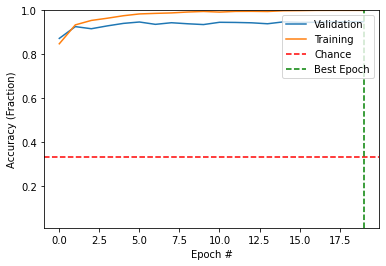

In [26]:
### YOUR CODE HERE
transfer = TransferClassifier(name = 'VGG16')
transfer.fit(x_train_norm, y_train_onehot, epochs=20, validation_data = (x_test_norm, y_test_onehot), shuffle=True, callbacks=[monitor])
plot_acc(transfer.history)

### END CODE


## Activity 4b. Transfer learning in tensorflow/keras

If you want to see how to implement transfer learning in tensorflow/keras, you can try this exercise!


### Exercise (Coding)


First, we will check out our keras toolbox's prebuilt machines and get VGG16.

Let's now load up VGG-16. We only want the convolution layers of the model - that is, the layers that are most responsible for giving the model its visual understanding. The 'Dense/Fully Connected (FC)' layers are thought to be more specific to the ImageNet challenge. 

In [29]:
# load the vgg network that is an 'expert' at 'imagenet' but do not include the FC layers
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (32, 32, 3))

Now, we're going to plug the VGG expert into a custom model. To do this, we do the following:

In [30]:
vgg_model = Sequential()
vgg_model.add(vgg_expert)

We want to add custom layers to our model... specifically, 
* `GlobalAveragePooling2D() # helps our vgg expert`
* `Dense(1024, activation = 'relu') # we've seen dense before!`
* `Dropout(0.3) # we've experimented with dropout before!`
* `Dense(512, activation = 'relu')`
* `Dropout(0.3)`
* `Dense(3, activation = 'sigmoid') # our output layer!` 


## Instructor-Led Discussion: Why do we add these models to the end of the network?

In [31]:
# add the extra layers here
### YOUR CODE HERE
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation='relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(3, activation = 'sigmoid')) # our output layer!

### END CODE

And finally compile it with 
* loss: `categorical_crossentropy`
* optimizer: `optimizers.SGD(lr = 1e-4, momentum = 0.95)`
* metrics: `accuracy`


In [33]:
# compile our model
### YOUR CODE HERE
vgg_model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.95), loss='categorical_crossentropy', metrics=['accuracy'])
### END CODE

Finally, hand our model its training manual, and let it train.

In [36]:
### YOUR CODE HERE
vgg_model.fit(x_train_norm, y_train_onehot, epochs=20, validation_data=(x_test_norm, y_test_onehot), shuffle=True, callbacks=[monitor])

### END CODE

Epoch 1/20
469/469 [==============================] - 9s 20ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.3384 - val_accuracy: 0.9377
Epoch 2/20
469/469 [==============================] - 9s 20ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.3515 - val_accuracy: 0.9370
Epoch 3/20
469/469 [==============================] - 9s 20ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.3793 - val_accuracy: 0.9317
Epoch 4/20
469/469 [==============================] - 9s 20ms/step - loss: 0.0095 - accuracy: 0.9969 - val_loss: 0.3224 - val_accuracy: 0.9387
Epoch 5/20
469/469 [==============================] - 9s 20ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.3316 - val_accuracy: 0.9383
Epoch 6/20
469/469 [==============================] - 9s 20ms/step - loss: 7.4359e-04 - accuracy: 1.0000 - val_loss: 0.3544 - val_accuracy: 0.9393
Epoch 7/20
469/469 [==============================] - 9s 20ms/step - loss: 8.1176e-04 - accuracy: 0.9999 - val_loss: 0.3723 - val_accuracy

Give your model its test, and see how well it works

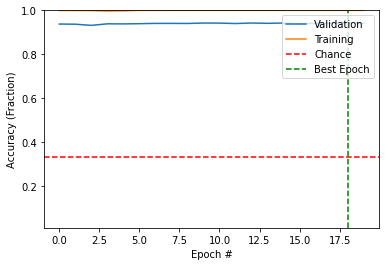

In [37]:
### YOUR CODE HERE
plot_acc(vgg_model.history)
### END CODE

Let's apply our expert model for vehicle detection!

In [ ]:
acc = sliding_predictions(vgg_model, windows, threshold=0.9)
print("The accuracy is {}".format(acc))

### Exercise (Discussion)



*   Do you think the CNN model and the pre-trained VGG model are better than our simple perceptron? Why?
*   Does the detector work better as we changed the image classifier?
*   How do you like our vehicle detector, a combination of sliding windows and a vehicle classifier? Can you list some weaknesses? 
*   Share with your classmates if you have ideas about a better detection algorithm!



